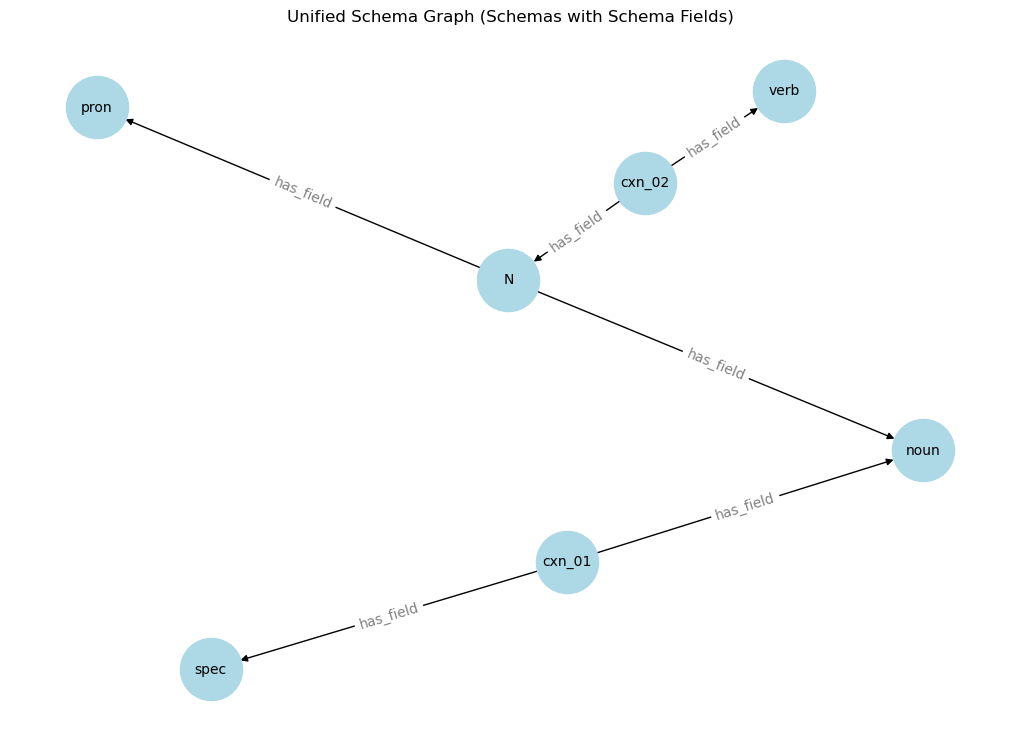

Chunked Stream Sentences:
Sentence 1:   Original: BOS spec noun EOS   Chunked : BOS cxn_01 EOS
Sentence 2:   Original: BOS pron verb EOS   Chunked : BOS pron verb EOS
Sentence 3:   Original: BOS spec noun verb EOS   Chunked : BOS cxn_01 verb EOS
Sentence 4:   Original: BOS pron noun EOS   Chunked : BOS pron noun EOS
Schema node count: 10
New sequence-based schemas added from stream: 3
Total has_field edges: 12
Schema node count: 10
New sequence-based schemas added: 3
Total has_field edges: 12
Schema node count: 10
Instance nodes now treated as Schema nodes
Total has_field edges: 12
Schema node count: 10
R-GAT model ready.
Model output shape: torch.Size([10, 10, 2])
Target shape: torch.Size([10])
Processed logits shape: torch.Size([10, 2])
Epoch 00, Loss: 0.7491
Model output shape: torch.Size([10, 10, 2])
Target shape: torch.Size([10])
Processed logits shape: torch.Size([10, 2])
Epoch 01, Loss: 3.0511
Model output shape: torch.Size([10, 10, 2])
Target shape: torch.Size([10])
Processed l

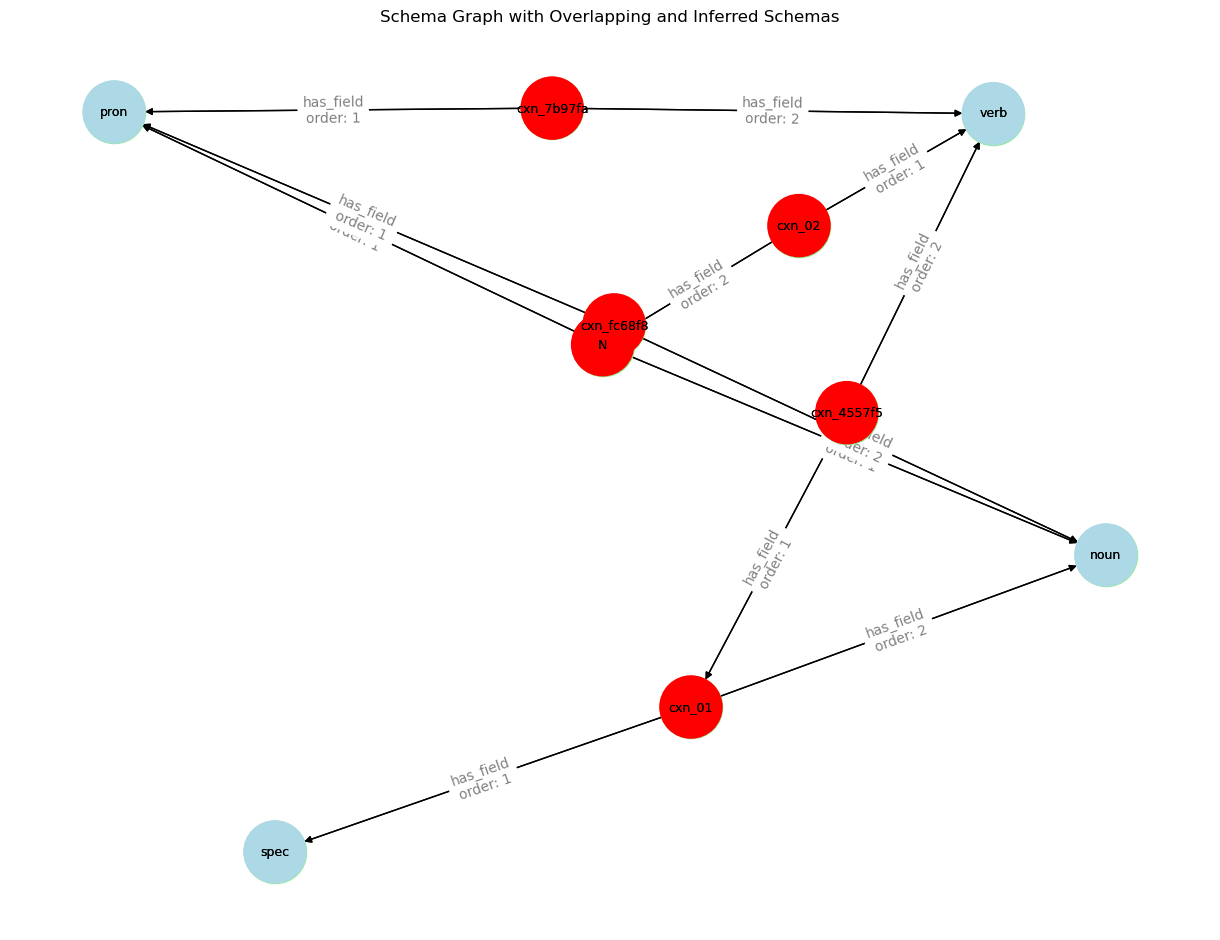

In [9]:
# Simplified Schema Graph: All nodes are Schemas and fields are also Schemas

import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import HeteroData

# Define schema nodes with AND/OR metadata
schema_nodes = [
    {"id": "cxn_01", "type": "Schema","logic": "AND"},
    {"id": "noun", "type": "Schema","logic": "OR"},
    {"id": "spec", "type": "Schema","logic": "OR"},
    {"id": "cxn_02", "type": "Schema","logic": "AND"},
    {"id": "verb", "type": "Schema","logic": "OR"},
    {"id": "pron", "type": "Schema","logic": "OR"},
    {"id": "N", "type": "Schema","logic": "OR"},
]

# Define schema relationships (has_field) with ordering
schema_edges = [
    ("cxn_01", "spec",1),
    ("cxn_01", "noun",2),
    ("cxn_02", "verb",1),
    ("cxn_02", "N",2),
    ("N", "noun",1),
    ("N", "pron",1)
]

# Create heterogeneous graph with only one node type: Schema
from transformers import BertTokenizer, BertModel

# Load BERT model and tokenizer
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
model = BertModel.from_pretrained(bert_model_name)

@torch.no_grad()
def get_bert_embedding(text: str) -> torch.Tensor:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=16)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]  # CLS token
data = HeteroData()
schema_embeddings = torch.stack([get_bert_embedding(node["id"]).squeeze(0) for node in schema_nodes])
data["Schema"].x = schema_embeddings
schema_index = {n["id"]: i for i, n in enumerate(schema_nodes)}

# Create has_field edges between Schema nodes
has_field_src = [schema_index[src] for src, dst, _ in schema_edges]
has_field_dst = [schema_index[dst] for src, dst, _ in schema_edges]
edge_index = torch.tensor([has_field_src, has_field_dst], dtype=torch.long)
data["Schema", "has_field", "Schema"].edge_index = edge_index

data["Schema", "rev_has_field", "Schema"].edge_index = edge_index.flip(0)

# Visualize the graph with NetworkX
G = nx.DiGraph()
for node in schema_nodes:
    G.add_node(node["id"], type="Schema")
for src, dst, order in schema_edges:
    G.add_edge(src, dst, relation="has_field")

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
node_labels = {n: n for n in G.nodes()}
edge_labels = {(u, v): d['relation'] for u, v, d in G.edges(data=True)}
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Unified Schema Graph (Schemas with Schema Fields)")
plt.axis('off')
plt.show()

# === Simulate Online Sequence Stream Processing ===
from collections import defaultdict
import hashlib
import random

# Streamed sentences (each with BOS and EOS)
stream = [
    ["BOS", "spec", "noun", "EOS"],
    ["BOS", "pron", "verb", "EOS"],
    ["BOS", "spec", "noun", "verb", "EOS"],
    ["BOS", "pron", "noun", "EOS"],
    ["BOS", "spec", "noun", "noun", "EOS"],
    ["BOS", "spec", "noun", "pron", "verb", "EOS"]
]

# === Match sequences against existing schemas to chunk ===
def replace_known_chunks(sentence, schema_defs):
    """Replace sequences in sentence using known schema definitions, allowing overlapping matches."""
    matches = []
    for i in range(len(sentence)):
        for schema, fields in schema_defs.items():
            length = len(fields)
            if i + length <= len(sentence) and tuple(sentence[i:i+length]) == tuple(fields):
                matches.append((i, i+length, schema))

    # Sort matches by start index
    matches.sort()

    # Build new sentence with replacements
    new_sentence = []
    i = 0
    while i < len(sentence):
        found = False
        for start, end, schema in matches:
            if i == start:
                new_sentence.append(schema)
                i = end
                found = True
                break
        if not found:
            new_sentence.append(sentence[i])
            i += 1
    return new_sentence

# Build mapping from schema ID to its ordered children (based on schema_edges)
schema_defs = {}
for schema, child, order in schema_edges:
    schema_defs.setdefault(schema, []).append((order, child))

# Sort fields by order
schema_defs = {k: [c for _, c in sorted(v)] for k, v in schema_defs.items()}

# Streamed sentences (each with BOS and EOS)
stream = [
    ["BOS", "spec", "noun", "EOS"],
    ["BOS", "pron", "verb", "EOS"],
    ["BOS", "spec", "noun", "verb", "EOS"],
    ["BOS", "pron", "noun", "EOS"]
]

# Chunk sentences using known schemas
chunked_stream = []

for sent in stream:
    inner = sent[1:-1]  # strip BOS and EOS
    base_chunks = replace_known_chunks(inner, schema_defs)
    chunked_stream.append(["BOS"] + base_chunks + ["EOS"])

# Simulate ambiguity by allowing multiple schemas to match overlapping subsequences
# Example: reuse known schemas in multiple compositions intentionally
# (This block encourages shared subsequences in new schema proposals)

# Initialize or update counts for sequence co-occurrence
seq_counter = defaultdict(int)

for sentence in chunked_stream:
    window = sentence[1:-1]  # exclude BOS and EOS for core chunk
    for i in range(len(window)):
        for j in range(i + 1, len(window) + 1):
            subseq = tuple(window[i:j])
            if len(subseq) > 1:
                seq_counter[subseq] += 1

# Filter frequent sequences (chunk candidates)
min_count = 1
new_schemas = [seq for seq, count in seq_counter.items() if count >= min_count]

# Generate new schema nodes and add them to the graph
for seq in new_schemas:
    schema_id = "cxn_" + hashlib.md5("_".join(seq).encode()).hexdigest()[:6]
    if schema_id not in schema_index:
        schema_nodes.append({"id": schema_id, "type": "Schema", "logic": "AND"})
        for i, token in enumerate(seq):
            schema_edges.append((schema_id, token, i + 1))

# Update schema index and embeddings
schema_index = {n["id"]: i for i, n in enumerate(schema_nodes)}
schema_embeddings = torch.stack([get_bert_embedding(node["id"]) for node in schema_nodes])
data["Schema"].x = schema_embeddings

# Rebuild edge index
has_field_src = [schema_index[src] for src, dst, _ in schema_edges]
has_field_dst = [schema_index[dst] for src, dst, _ in schema_edges]
edge_index = torch.tensor([has_field_src, has_field_dst], dtype=torch.long)
data["Schema", "has_field", "Schema"].edge_index = edge_index

data["Schema", "rev_has_field", "Schema"].edge_index = edge_index.flip(0)

# Confirm graph update
print("Chunked Stream Sentences:")
for i, (original, chunked) in enumerate(zip(stream, chunked_stream)):
    print(f"Sentence {i+1}:   Original: {' '.join(original)}   Chunked : {' '.join(chunked)}")

print("Schema node count:", len(schema_nodes))
print("New sequence-based schemas added from stream:", len(new_schemas))
print("Total has_field edges:", edge_index.shape[1])
print("Schema node count:", len(schema_nodes))
print("New sequence-based schemas added:", len(new_schemas))
print("Total has_field edges:", edge_index.shape[1])
print("Schema node count:", len(schema_nodes))
print("Instance nodes now treated as Schema nodes")
print("Total has_field edges:", edge_index.shape[1])
print("Schema node count:", len(schema_nodes))

# === R-GAT GNN MODEL PREPARATION ===
# Define labels for supervised task: Predict 'logic' type (AND=0, OR=1)
logic_map = {"AND": 0, "OR": 1}
data["Schema"].y = torch.tensor([logic_map[n["logic"]] for n in schema_nodes])
data["Schema"].train_mask = torch.ones(len(schema_nodes), dtype=torch.bool)  # full supervision
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F

class GCNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=2):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations=1)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations=1)

    def forward(self, x, edge_index, edge_type):
        x = self.conv1(x, edge_index, edge_type)
        x = F.elu(x)
        x = self.conv2(x, edge_index, edge_type)
        return x
        

# Create model instance
schema_x = data["Schema"].x
edge_index = data["Schema", "has_field", "Schema"].edge_index
edge_type = torch.zeros(edge_index.size(1), dtype=torch.long)  # only one relation type for now

model = GCNModel(
    in_channels=schema_x.size(-1),
    hidden_channels=64,
    out_channels=2
)
print("R-GAT model ready.")

# === DEVICE SETUP ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
schema_x = schema_x.to(device)
edge_index = edge_index.to(device)
edge_type = edge_type.to(device)
data["Schema"].y = data["Schema"].y.to(device)
data["Schema"].train_mask = data["Schema"].train_mask.to(device)

# === TRAINING LOOP ===
# Change the loss calculation in your training loop to fix the shape mismatch
# Training loop with fixed mask dimensions

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(20):
    optimizer.zero_grad()
    out = model(schema_x, edge_index, edge_type)
    
    # Debug prints
    print("Model output shape:", out.shape)        # [10, 10, 2]
    print("Target shape:", data["Schema"].y.shape) # [10]
    
    # Option 1: Take the first "row" for each node
    logits = out[:, 0, :]  # Shape: [10, 2]
    
    print("Processed logits shape:", logits.shape)  # Should be [10, 2]
    
    # Get the target
    target = data["Schema"].y
    
    # Verify shapes match in the first dimension
    assert logits.size(0) == target.size(0), f"Batch size mismatch: logits {logits.size(0)}, target {target.size(0)}"
    
    # Use standard cross entropy
    loss = F.cross_entropy(logits, target)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch:02d}, Loss: {loss.item():.4f}")
    
G_full = nx.DiGraph()

# Highlight overlapping schemas based on reuse of child subsequences
from collections import Counter

# Count how many times each child appears in schema_edges
child_counter = Counter(dst for _, dst, _ in schema_edges)

# Add schema nodes
for node in schema_nodes:
    child_reuse = sum(1 for s, d, _ in schema_edges if s == node['id'] and child_counter[d] > 1)
    if child_reuse >= 1:
        node_color = 'red'  # Overlapping (shared subsequences)
    elif node['id'].startswith("cxn_"):
        node_color = 'orange'  # Inferred schema
    else:
        node_color = 'lightblue'
    G_full.add_node(node["id"], type="Schema", color=node_color)

# Add has_field edges with order metadata (including instance-as-schema edges)
for src, dst, order in schema_edges:
    G_full.add_edge(src, dst, relation="has_field", order=order)

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G_full, seed=42)
node_labels = {n: n for n in G_full.nodes()}
edge_labels = {(u, v): f"{d['relation']}\norder: {d.get('order', '')}" for u, v, d in G_full.edges(data=True)}
nx.draw(G_full, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G_full, pos, edge_labels=edge_labels, font_color='gray')
colors = [G_full.nodes[n].get("color", "lightblue") for n in G_full.nodes()]
nx.draw(G_full, pos, with_labels=True, node_color=colors, node_size=2000, font_size=9)
nx.draw_networkx_edge_labels(G_full, pos, edge_labels=edge_labels, font_color='gray')
plt.title("Schema Graph with Overlapping and Inferred Schemas")
plt.axis('off')
plt.show()
